# 4. Calculate variance of Stokes and anti-Stokes measurements

The goal of this notebook is to estimate the variance of the noise of the Stokes measurement. The measured Stokes and anti-Stokes signals contain noise that is distributed approximately normal. We need to estimate the variance of the noise to:
- Perform a weighted calibration 
- Construct confidence intervals

In [1]:
import os

from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


And we define the sections as we learned from the previous notebook. Sections are required to calculate the variance in the Stokes.

In [3]:
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

Lets first read the documentation about the `ds.variance_stokes` method.

In [4]:
print(ds.variance_stokes.__doc__) 

Calculates the variance between the measurements and a best fit
        at each reference section. This fits a function to the nt * nx
        measurements with ns * nt + nx parameters, where nx are the total
        number of obervation locations along all sections. The temperature is
        constant along the reference sections, so the expression of the
        Stokes power can be split in a time series per reference section and
        a constant per observation location.

        Assumptions: 1) the temperature is the same along a reference
        section.

        Idea from discussion at page 127 in Richter, P. H. (1995). Estimating
        errors in least-squares fitting.

        Parameters
        ----------
        reshape_residuals
        st_label : str
            label of the Stokes, anti-Stokes measurement.
            E.g., ST, AST, REV-ST, REV-AST
        sections : dict, optional
            Define sections. See documentation

        Returns
        -------
        

In [5]:
I_var, residuals = ds.variance_stokes(st_label='ST')
print("The variance of the Stokes signal along the reference sections "
      "is approximately {} on a {} sec acquisition time".format(I_var, ds.userAcquisitionTimeFW.data[0]))

The variance of the Stokes signal along the reference sections is approximately 8.181920419777416 on a 2.0 sec acquisition time


/Users/bfdestombe/Projects/dts-calibration/python-dts-calibration/src/dtscalibration/plot.py:300: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if (np.issubdtype(resid[time_dim].dtype, np.float) or
/Users/bfdestombe/Projects/dts-calibration/python-dts-calibration/src/dtscalibration/plot.py:301: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  np.issubdtype(resid[time_dim].dtype, np.int)):
/Users/bfdestombe/Projects/dts-calibration/python-dts-calibration/.tox/docs/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/bfdestombe/Projects/dts-calibration/python-dts-calibration/.tox/docs/lib/python3.6/site-packages/xarray/core/nanops.py:161: Run

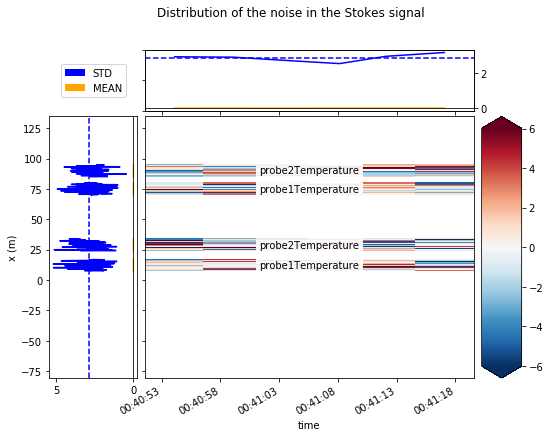

In [6]:
from dtscalibration import plot

fig_handle = plot.plot_residuals_reference_sections(
        residuals,
        sections,
        title='Distribution of the noise in the Stokes signal',
        plot_avg_std=I_var ** 0.5,
        plot_names=True,
        robust=True,
        units='',
        method='single')

The residuals should be normally distributed and independent from previous time steps and other points along the cable. If you observe patterns in the residuals plot (above), it might be caused by:
- The temperature in the calibration bath is not uniform
- Attenuation caused by coils/sharp bends in cable
- Attenuation caused by a splice

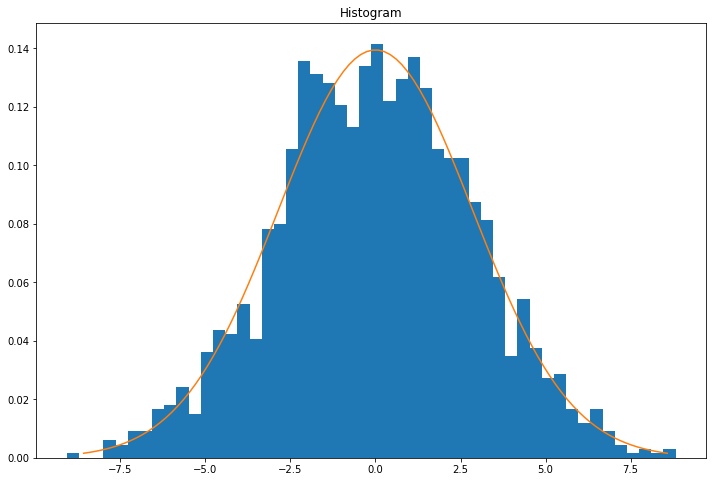

In [7]:
import scipy
import numpy as np

sigma = residuals.std()
mean = residuals.mean()
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
approximated_normal_fit = scipy.stats.norm.pdf(x, mean, sigma)
residuals.plot.hist(bins=50, figsize=(12, 8), density=True)
plt.plot(x, approximated_normal_fit);

We can follow the same steps to calculate the variance from the noise in the anti-Stokes measurments by setting `st_label='AST` and redo the steps.